Download torch and torchvision

In [25]:
# pip install torch

In [26]:
# pip install torchvision

Initialization

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler, Dataset, DataLoader, SubsetRandomSampler
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
import pandas as pd
import numpy as np

USE_GPU = True
dtype = torch.float32 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    device = torch.device('cpu')
    print("No GPU available. Training will run on CPU.")

No GPU available. Training will run on CPU.


If the output is "using device: cpu": download CUDA toolkit (https://developer.nvidia.com/cuda-downloads)
https://pytorch.org/get-started/locally/

In [28]:
# data augmentation
transform = v2.Compose([
                v2.ToImage(), 
                v2.ToDtype(torch.float32, scale=True),
                # v2.RandomHorizontalFlip(),
                v2.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.3, 0.3)),
                # v2.RandomChannelPermutation(),
                # v2.RandomErasing(p=0.5, scale=(0.05, 0.3), ratio=(1, 1), value='random'),
                v2.RandomRotation(degrees=30)])

In [29]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    # return classes
    def classes(self):
        return self.data.classes

In [30]:
# creat a dictionary that maps index to label
data_dir='ClassificationDataset_label/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [31]:
button_train = CropButtonDataset('ClassificationDataset_label/train', transform=transform)
loader_train = DataLoader(button_train, batch_size=200, shuffle=True)

button_val = CropButtonDataset('ClassificationDataset_label/val', transform=transform)
loader_val = DataLoader(button_val, batch_size=14, shuffle=True)

button_test = CropButtonDataset('ClassificationDataset_label/test', transform=transform)
loader_test = DataLoader(button_test, batch_size=14, shuffle=False)

Check If load correctly

In [32]:
loader_train

In [33]:
for images, labels in loader_val:
    print("Batch loaded!")
    print("Images shape:", images.shape)
    print("Labels:", labels)
    break


Batch loaded!
Images shape: torch.Size([14, 3, 320, 320])
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0])


Model setup

In [34]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [35]:
def check_accuracy_final(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype).unsqueeze(1)
            scores = model(x)
            preds = (torch.sigmoid(scores) > 0.5).long()
            num_correct += (preds == y.long()).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc

def train(model, optimizer, epochs=10):
    x1 = list(range(len(loader_train) * epochs))
    x2 = []
    y1 = []
    y2 = []
    model = model.to(device=device)
    criterion = nn.BCEWithLogitsLoss()
    cnt = 0
    total_cnt = epochs * len(loader_train)
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype).unsqueeze(1)

            scores = model(x)
            loss = criterion(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y1.append(loss.item())

            print("iteration: " +  str(cnt) + "/" + str(total_cnt) + ": loss = " + str(loss.item()))
            if cnt % 5 == 0:
                acc_val = check_accuracy_final(loader_val, model)
                print("val_acc = " + str(acc_val))
                x2.append(cnt)
                y2.append(acc_val)

            cnt += 1
    return (x1, y1, x2, y2)

def plotpic(data):
  x1, y1, x2, y2 = data
  plt.figure()
  plt.plot(x1, y1, marker='.')
  plt.xlabel('Iteratoin')
  plt.ylabel('Loss')
  plt.title('Loss')
  plt.grid(True)

  plt.figure()
  plt.plot(x2, y2, marker='o')
  plt.xlabel('Iteratoin')
  plt.ylabel('Val Acc')
  plt.title('Val Acc')
  plt.grid(True)
  plt.show()

In [36]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(negative_slope=0.01),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.4),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(negative_slope=0.01),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.4),

    nn.Flatten(),
    nn.Linear(64 * 80 * 80, 256),
    nn.LeakyReLU(negative_slope=0.01),
    nn.Linear(256, 1),
)

In [37]:
criterion = nn.BCEWithLogitsLoss()
sgdMNb = optim.SGD(model.parameters(), lr=1e-5,
                     momentum=0.8, nesterov=True)
adamw = optim.AdamW(model.parameters(), lr=1e-3,
                        weight_decay=1e-2)

Train

In [38]:
data = train(model, sgdMNb, epochs=10)

iteration: 0/10: loss = 0.6971666216850281
val_acc = 0.5
iteration: 1/10: loss = 0.6938840746879578
iteration: 2/10: loss = 0.6804767847061157
iteration: 3/10: loss = 0.6776517033576965
iteration: 4/10: loss = 0.701021134853363
iteration: 5/10: loss = 0.6731568574905396
val_acc = 0.5
iteration: 6/10: loss = 0.6855558156967163
iteration: 7/10: loss = 0.6887936592102051


In [ ]:
# from itertools import product
# lr = 10 ** np.random.uniform(-3, -6, (10,))
# mm = np.random.uniform(0.8, 0.99, (10,))
# for l, m in product(lr, mm):
#     sgdMNb = optim.SGD(model.parameters(), lr=l,
#                      momentum=m, nesterov=True)
#     data = train(model, sgdMNb, epochs=10)

iteration: 0/10: loss = 0.7171961069107056
val_acc = 0.5
iteration: 1/10: loss = 0.7220160365104675
iteration: 2/10: loss = 6.973464012145996


KeyboardInterrupt: 

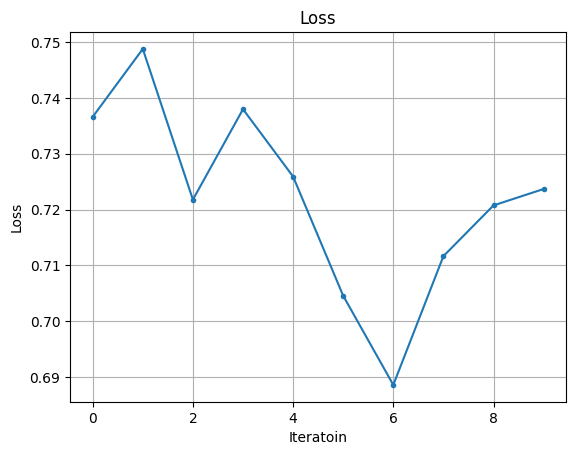

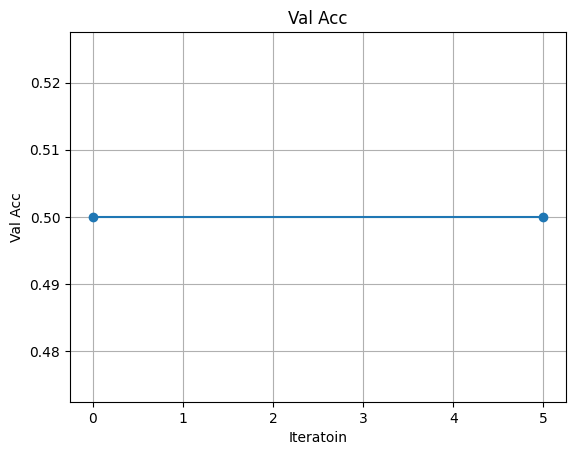

In [ ]:
plotpic(data)